## Building an Open Images classifier dataset

In this notebook we will transform the metadata and image files that we have into a dataset file formatted for input into a machine learning model.

### Prelude

At this point we've already run the script that selected relevant images and and placed them in the `../data/raw/` directory. 

In [1]:
%ls ../data/raw/ | head

10005363385_643a271403_o.jpg
10049481156_6cdc5d23be_o.jpg
10055684643_7a3b91aa52_o.jpg
10068596516_824cb1f99a_o.jpg
10075048456_305828dc0c_o.jpg
10082195766_2798719478_o.jpg
10084373336_1293fc7a41_o.jpg
10097620965_a2d3bd267c_o.jpg
10120084466_e0fbb7744d_o.jpg
101206030_5a3dff2d9c_o.jpg


### Quick inspection

Let's peak at some example images from the dataset.

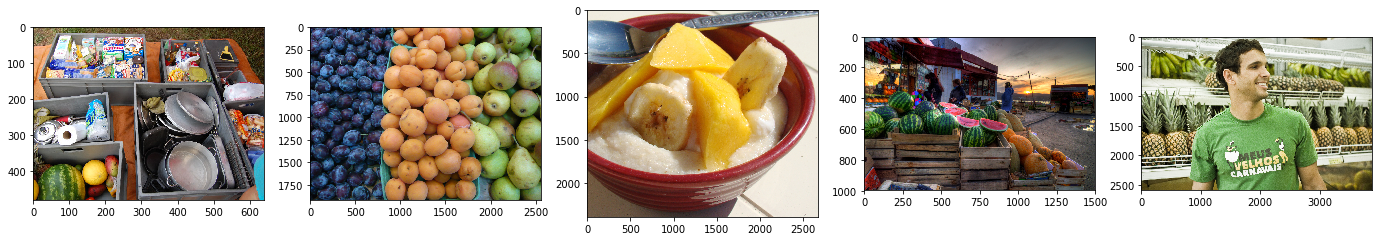

In [1]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline
import os

fig, axarr = plt.subplots(1, 5, figsize=(24, 4))
for i, img in enumerate(os.listdir('../data/raw/')[:5]):
    axarr[i].imshow(imread('../data/raw/' + img))

### Packaging the data

However, before we can move on to actually training the model, we must subselect the relevant image metadata, and package that up alongside the raw images so that we have a common starting point.

The script we wrote for downloading relevant training images does all of the work required, but doesn't save that anywhere because it is solely responsible for downloading images, not for saving metadata to disc.

The following segment of code is copied from that routine, and it recreates the relevant metadata.

In [2]:
import pandas as pd

categories = ['Apple', 'Banana', 'Cantaloupe', 'Common fig', 'Grape', 'Grapefruit', 'Lemon', 
              'Mango', 'Orange', 'Peach', 'Pear', 'Pineapple', 'Pomegranate', 'Watermelon',
              'Strawberry', 'Tomato']

kwargs = {'header': None, 'names': ['LabelID', 'LabelName']}
class_names = pd.read_csv("../data/metadata/image-class-names.csv", **kwargs)
train_boxed = pd.read_csv("../data/metadata/train-annotations-bbox.csv", index_col=0)
image_ids = pd.read_csv("../data/metadata/train-images-ids.csv", index_col=0)
label_map = dict(class_names.set_index('LabelName').loc[categories, 'LabelID']
                 .to_frame().reset_index().set_index('LabelID')['LabelName'])
label_values = set(label_map.keys())
relevant_training_images = train_boxed[train_boxed.LabelName.isin(label_values)]
relevant_flickr_urls = (relevant_training_images.set_index('ImageID')
                        .join(image_ids.set_index('ImageID'))
                        .loc[:, 'OriginalURL'])
relevant_flickr_img_metadata = (relevant_training_images.set_index('ImageID').loc[relevant_flickr_urls.index]
                                .pipe(lambda df: df.assign(LabelValue=df.LabelName.map(lambda v: label_map[v]))))

/Users/alex/miniconda3/envs/open-images-dev/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
u_relevant_flickr_urls = pd.Series(relevant_flickr_urls.unique(), 
                                   index=relevant_flickr_urls.index.unique(),
                                   name='OriginalURL')

X_meta = (relevant_training_images
          .set_index('ImageID')
          .join(u_relevant_flickr_urls.map(lambda v: v.split("/")[-1]), how='left')
          .reset_index()
          .pipe(lambda df: df.assign(LabelName=df.LabelName.map(lambda l: label_map[l])))
          .reset_index(drop=True)
         )

In [4]:
X_meta.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,OriginalURL
0,0000a16e4b057580,xclick,Watermelon,1,0.000000,0.183750,0.146667,0.282500,1,1,0,0,0,516015907_5b1c0effdb_o.jpg
1,0000a16e4b057580,xclick,Watermelon,1,0.027500,0.156250,0.025000,0.198333,1,0,0,0,0,516015907_5b1c0effdb_o.jpg
2,0000a16e4b057580,xclick,Watermelon,1,0.279375,0.410625,0.070833,0.184167,1,0,0,0,0,516015907_5b1c0effdb_o.jpg
3,0000a16e4b057580,xclick,Watermelon,1,0.551875,0.719375,0.048333,0.227500,1,0,0,0,0,516015907_5b1c0effdb_o.jpg
4,0000a16e4b057580,xclick,Watermelon,1,0.568750,0.921250,0.262500,0.734167,0,0,0,0,0,516015907_5b1c0effdb_o.jpg


The dataset includes images which have been deleted, which are replaced with a placeholder image by the Flickr service. We can only detect that an image has been deleted by inspecting how many channels we see when we read the image in. One channel means grayscale, which in turn means the image is a placeholder.

In [6]:
import numpy as np
from PIL import Image  # pip install pillow
from tqdm import tqdm_notebook

def get_image_arr(img):
    """Given an image URL, returns that image read out from local disk into a numpy array."""
    return np.asarray(Image.open('../data/raw/' + img))

def is_non_unary_channel(img_arr):
    """Returns whether or not the given image has multiple channels or not (expect 3: RGB)."""
    return len(img_arr.shape) == 3 and img_arr.shape[2] > 1

def is_non_unary(img_srs, is_non_unary_list, is_non_unary_map):
    """Given an image Series, determines whether or not the given image is unary or not."""
    if img_srs.ImageID in is_non_unary_map:
        is_non_unary_list.append(is_non_unary_map[img_srs.ImageID])
    else:
        res = is_non_unary_channel(get_image_arr(srs.OriginalURL))
        is_non_unary_list.append(res)
        is_non_unary_map.update({srs.ImageID: res})
    return is_non_unary_list, is_non_unary_map


is_non_unary_list = []
is_non_unary_map = {}
for idx, srs in tqdm_notebook(list(X_meta.iterrows())):
    if idx != len(is_non_unary_list):
        assert False
    
    is_non_unary_list, is_non_unary_map =\
        is_non_unary(srs, is_non_unary_list, is_non_unary_map)

/Users/alex/miniconda3/envs/open-images-dev/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3263561744 bytes but only got 0. Skipping tag 8
  " Skipping tag %s" % (size, len(data), tag))
/Users/alex/miniconda3/envs/open-images-dev/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4568514560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/alex/miniconda3/envs/open-images-dev/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2284978176 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/alex/miniconda3/envs/open-images-dev/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19600506880 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (si

/Users/alex/miniconda3/envs/open-images-dev/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8589934590 bytes but only got 170. Skipping tag 34855
  " Skipping tag %s" % (size, len(data), tag))
/Users/alex/miniconda3/envs/open-images-dev/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 350224418 bytes but only got 0. Skipping tag 1045
  " Skipping tag %s" % (size, len(data), tag))
/Users/alex/miniconda3/envs/open-images-dev/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 786434 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/alex/miniconda3/envs/open-images-dev/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131099 bytes but only got 0. Skipping tag 8
  " Skipping tag %s" % (siz

In [7]:
X_meta = X_meta[is_non_unary_list]

The machine learning model takes the raw images as input. In order for that to work, the input images must all be the same size. The boxed images included in this dataset are _not_ all the same size (or orientation, or anything else like that). They are in this way representative of true image classification task out "in the wild", as opposed to more templatized image recognition tasks like MNIST and Fashion-MNIST.

In [8]:
import matplotlib.pyplot as plt

def get_bounds(img_arr, srs):
    img_xmax, img_ymax = img_arr.shape[1], img_arr.shape[0]
    bbox_x_min, bbox_x_max = srs.XMax * img_xmax, srs.XMin * img_xmax
    bbox_y_min ,bbox_y_max = srs.YMax * img_ymax, srs.YMin * img_ymax
    return bbox_x_max, bbox_x_min, bbox_y_max, bbox_y_min

def get_bbox_points(bounds):
    return [[bounds[0], bounds[0], bounds[1], bounds[1], bounds[0]], 
            [bounds[2], bounds[3], bounds[3], bounds[2], bounds[2]]]

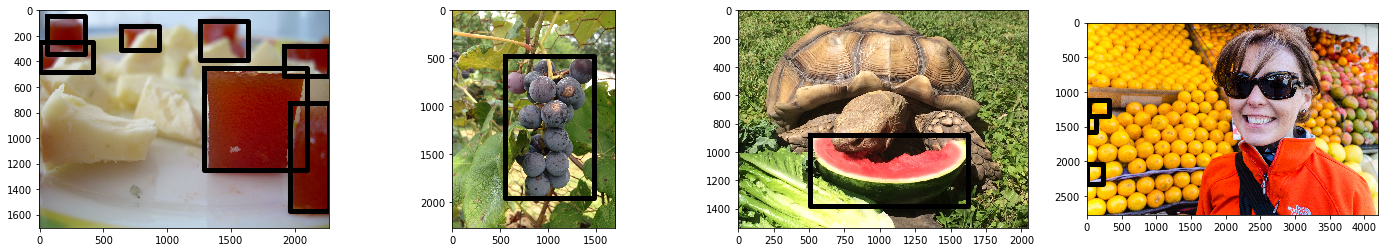

In [46]:
fig, axarr = plt.subplots(1, 4, figsize=(24, 4))
kwargs = {'color': 'black', 'linewidth': 5}

axarr[0].imshow(np.asarray(Image.open('../data/raw/' + X_meta.iloc[0].OriginalURL)))
axarr[0].plot(
    *get_bbox_points(
        get_bounds(np.asarray(Image.open('../data/raw/' + X_meta.iloc[0].OriginalURL)), X_meta.iloc[0])
    ),
    **kwargs
)
axarr[0].plot(
    *get_bbox_points(
        get_bounds(np.asarray(Image.open('../data/raw/' + X_meta.iloc[1].OriginalURL)), X_meta.iloc[1])
    ),
    **kwargs
)
axarr[0].plot(
    *get_bbox_points(
        get_bounds(np.asarray(Image.open('../data/raw/' + X_meta.iloc[2].OriginalURL)), X_meta.iloc[2])
    ),
    **kwargs
)
axarr[0].plot(
    *get_bbox_points(
        get_bounds(np.asarray(Image.open('../data/raw/' + X_meta.iloc[3].OriginalURL)), X_meta.iloc[3])
    ),
    **kwargs
)
axarr[0].plot(
    *get_bbox_points(
        get_bounds(np.asarray(Image.open('../data/raw/' + X_meta.iloc[4].OriginalURL)), X_meta.iloc[4])
    ),
    **kwargs
)
axarr[0].plot(
    *get_bbox_points(
        get_bounds(np.asarray(Image.open('../data/raw/' + X_meta.iloc[5].OriginalURL)), X_meta.iloc[5])
    ),
    **kwargs
)
axarr[0].plot(
    *get_bbox_points(
        get_bounds(np.asarray(Image.open('../data/raw/' + X_meta.iloc[6].OriginalURL)), X_meta.iloc[6])
    ),
    **kwargs
)


axarr[1].imshow(np.asarray(Image.open('../data/raw/' + X_meta.iloc[7].OriginalURL)))
axarr[1].plot(
    *get_bbox_points(
        get_bounds(np.asarray(Image.open('../data/raw/' + X_meta.iloc[7].OriginalURL)), X_meta.iloc[7])
    ),
    **kwargs
)

axarr[2].imshow(np.asarray(Image.open('../data/raw/' + X_meta.iloc[8].OriginalURL)))
axarr[2].plot(
    *get_bbox_points(
        get_bounds(np.asarray(Image.open('../data/raw/' + X_meta.iloc[8].OriginalURL)), X_meta.iloc[8])
    ),
    **kwargs
)

axarr[3].imshow(np.asarray(Image.open('../data/raw/' + X_meta.iloc[9].OriginalURL)))
axarr[3].plot(
    *get_bbox_points(
        get_bounds(np.asarray(Image.open('../data/raw/' + X_meta.iloc[9].OriginalURL)), X_meta.iloc[9])
    ),
    **kwargs
)
axarr[3].plot(
    *get_bbox_points(
        get_bounds(np.asarray(Image.open('../data/raw/' + X_meta.iloc[10].OriginalURL)), X_meta.iloc[10])
    ),
    **kwargs
)
axarr[3].plot(
    *get_bbox_points(
        get_bounds(np.asarray(Image.open('../data/raw/' + X_meta.iloc[11].OriginalURL)), X_meta.iloc[11])
    ),
    **kwargs
)

In [9]:
from skimage.transform import resize

def get_cropped_image_arr(img, idx):
    """Given an image URL, returns that image cropped read out from local disk into a numpy array."""
    return np.asarray(Image.open('../data/images/' + img.split('.')[0] + '_' + str(idx) + '.jpg'))   

def crop_image_to_bbox(img_arr, X_meta_srs):
    """Given an image array, crops the image to just the bounding box provided."""
    shape = img_arr.shape
    x_min, x_max, y_min, y_max = get_bounds(img_arr, X_meta_srs)
    x_min, x_max = int(np.floor(x_min)), int(np.ceil(x_max))
    y_min, y_max = int(np.floor(y_min)), int(np.ceil(y_max))
    return img_arr[y_min:y_max, x_min:x_max]

def resize_img_arr(img_arr):
    """Given an image array, resizes that image to a standard size (aspect ratio is not preserved)."""
    return resize(img_arr, (128, 128), anti_aliasing=True, mode='constant', preserve_range=True)

In [22]:
def generate_cropped_images(X_meta):
    return (X_meta
     # use the metadata to select images and generate cropped numpy arrays
     .pipe(lambda df: 
           df.apply(
               lambda srs: crop_image_to_bbox(
                   get_image_arr(srs.OriginalURL),
                   srs
               ), axis='columns')
      ))

def save_cropped_images_to_disk(img_arrs, img_meta_df):
    for (img_arr, (idx, img_meta_srs)) in zip(img_arrs, img_meta_df.iterrows()):
        Image.fromarray(img_arr).convert('RGB').save(
            '../data/images_cropped/' + img_meta_srs.LabelName.replace(" ", "_") + "/" +
            img_meta_srs.OriginalURL.split(".")[0] + "_" + str(idx) + ".jpg"
        )

In [11]:
!mkdir ../data/images_cropped
!mkdir ../data/images_cropped/Apple
!mkdir ../data/images_cropped/Banana
!mkdir ../data/images_cropped/Cantaloupe
!mkdir ../data/images_cropped/Common_fig
!mkdir ../data/images_cropped/Grape
!mkdir ../data/images_cropped/Grapefruit
!mkdir ../data/images_cropped/Lemon
!mkdir ../data/images_cropped/Mango
!mkdir ../data/images_cropped/Orange
!mkdir ../data/images_cropped/Peach
!mkdir ../data/images_cropped/Pear
!mkdir ../data/images_cropped/Pineapple
!mkdir ../data/images_cropped/Pomegranate
!mkdir ../data/images_cropped/Watermelon
!mkdir ../data/images_cropped/Strawberry
!mkdir ../data/images_cropped/Tomato

In [13]:
!mkdir ../data/training/

In [23]:
from tqdm import tqdm_notebook

# this process is chunked b/c reading entire images into numpy arrays is very expensive
# you'll run out of memory very easiy because some of the images are very very large
for i in tqdm_notebook(range(X_meta.index.max() // 20 + 1)):
    n_s, n_e = i * 20, i * 20 + 20
    X_meta_fragment = X_meta.iloc[n_s:n_e]
    cropped_imgs = generate_cropped_images(X_meta_fragment)
    save_cropped_images_to_disk(cropped_imgs, X_meta_fragment)

/Users/alex/miniconda3/envs/open-images-dev/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3263561744 bytes but only got 0. Skipping tag 8
  " Skipping tag %s" % (size, len(data), tag))
/Users/alex/miniconda3/envs/open-images-dev/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4568514560 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/alex/miniconda3/envs/open-images-dev/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2284978176 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/Users/alex/miniconda3/envs/open-images-dev/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 19600506880 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (si

/Users/alex/miniconda3/envs/open-images-dev/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8589934590 bytes but only got 170. Skipping tag 34855
  " Skipping tag %s" % (size, len(data), tag))
/Users/alex/miniconda3/envs/open-images-dev/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 350224418 bytes but only got 0. Skipping tag 1045
  " Skipping tag %s" % (size, len(data), tag))
/Users/alex/miniconda3/envs/open-images-dev/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 786434 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/Users/alex/miniconda3/envs/open-images-dev/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131099 bytes but only got 0. Skipping tag 8
  " Skipping tag %s" % (siz

In [36]:
newnames = []

for idx, srs in X_meta.iterrows():
    newname = srs.LabelName.replace(" ", "_") + "/" +\
        srs.OriginalURL.split(".")[0] + "_" + str(idx) + ".jpg"
    newnames.append(newname)
    
X_meta = X_meta.assign(CroppedImageURL=newnames)

In [37]:
X_meta.to_csv("../data/training/X_meta.csv", index=False)